## Семинар 7: "Методы оптимизации"

ФИО: Корнеева александра Михайловна


In [91]:
import numpy as np
from sklearn.datasets import fetch_mldata
#from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [3]:
class Optimizer():
    def __init__(self, variables, df, weight):
        self.variables = variables
        self.df = df
        self.theta = np.array(weight, dtype='float64')
        
    def step(self, loss):
        pass


In [4]:
class GD(Optimizer):
    def __init__(self, variables, df, weight, learning_rate=0.1):
        super(GD, self).__init__(variables, df, weight)
        self.learning_rate = learning_rate
        
    def step(self):
        self.theta -= self.learning_rate * self.df(self.theta)

In [5]:
class Momentum(Optimizer):
    def __init__(self, variables, df, weight, learning_rate=0.1, gamma=0.9):
        super(Momentum, self).__init__(variables, df, weight)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.nu = 0
        
    def step(self):
        self.nu = self.gamma * self.nu + self.learning_rate * self.df(self.theta)
        self.theta -= self.nu

In [6]:
class NAG(Optimizer):
    def __init__(self, variables, df, weight, learning_rate=0.1, gamma=0.9):
        super(NAG, self).__init__(variables, df, weight)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.nu = 0
        
    def step(self):
        self.nu = self.gamma * self.nu + self.learning_rate * self.df(self.theta - self.gamma * self.nu)
        self.theta -= self.nu

In [26]:
class Adagrad(Optimizer):
    def __init__(self, variables, df, weight, learning_rate=0.01, eps=1e-8):
        super(Adagrad, self).__init__(variables, df, weight)
        self.learning_rate = learning_rate
        self.G =  np.zeros_like(self.theta, dtype='float64')
        self.eps = eps
        
    def step(self):
        self.G += self.df(self.theta)**2
        self.theta -= self.learning_rate * self.df(self.theta) / np.sqrt(self.G + self.eps)

In [33]:
class Adadelta(Optimizer):
    def __init__(self, variables, df, weight, learning_rate=0.01, eps=1e-8, gamma=0.9):
        super(Adadelta, self).__init__(variables, df, weight)
        self.learning_rate = learning_rate
        self.eps = eps
        self.gamma = gamma
        self.exp_G = np.zeros_like(self.theta, dtype='float64')
        self.delta_theta = np.zeros_like(self.theta, dtype='float64')
        
    def step(self):
        grad = self.df(self.theta)
        self.exp_G = self.gamma * self.exp_G + (1 - self.gamma) * grad**2
        self.delta_theta = self.learning_rate * grad / np.sqrt(self.exp_G + self.eps)
        self.theta -= self.delta_theta
        

In [38]:
class Adam(Optimizer):
    def __init__(self, variables, df, weight, learning_rate=0.01, eps=1e-8, b1=0.9, b2=0.999):
        super(Adam, self).__init__(variables, df, weight)
        self.learning_rate = learning_rate
        self.eps = eps
        self.m = np.zeros_like(self.theta, dtype='float64')
        self.nu = np.zeros_like(self.theta, dtype='float64')
        self.b1 = b1
        self.b2 = b2
        self.i = 0
        
    def step(self):
        self.i += 1
        grad = self.df(self.theta)
        
        self.m = self.b1 * self.m + (1 - self.b1) * grad
        self.nu = self.b2 * self.nu + (1 - self.b2) * grad**2
        
        m_ = self.m / (1 - self.b1**self.i)
        nu_ = self.nu / (1 - self.b2**self.i)

        self.theta -= self.learning_rate * m_ / (np.sqrt(nu_) + self.eps)

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [40]:
def contour_plot(func, x_s, x_e, y_s, y_e, delta=0.05):
    x = np.arange(x_s, x_e, delta)
    y = np.arange(y_s, y_e, delta)
    X, Y = np.meshgrid(x, y)
    
    Z = np.array([func(x) for x in np.c_[X.reshape(-1,1), Y.reshape(-1,1)]]).reshape(X.shape[0], X.shape[1])
    CS = plt.contour(X, Y, Z)
    plt.clabel(CS, fmt='%1.1f', inline=1, fontsize=10)

In [130]:
def plot(f, df, POINT, N):
    plt.figure(figsize=(10, 7))


    x = np.arange(-3, 3, 0.05)
    y = np.arange(-3, 3, 0.05)
    X, Y = np.meshgrid(x, y)

    Z = np.array([f(x) for x in np.c_[X.reshape(-1,1), Y.reshape(-1,1)]]).reshape(X.shape[0], X.shape[1])

    plt.clabel(plt.contour(X, Y, Z))

    for method in [GD, Momentum, NAG, Adagrad, Adadelta, Adam]:
        thetas = np.empty((N, 2))
        optimizer = method(f, df, POINT, learning_rate=0.01)
        for i in range(N):
            thetas[i] = optimizer.theta
            optimizer.step()
        plt.scatter(thetas[-1, 0], thetas[-1, 1], label = optimizer.__class__.__name__)
        plt.plot(thetas[:, 0], thetas[:, 1])
    plt.legend()

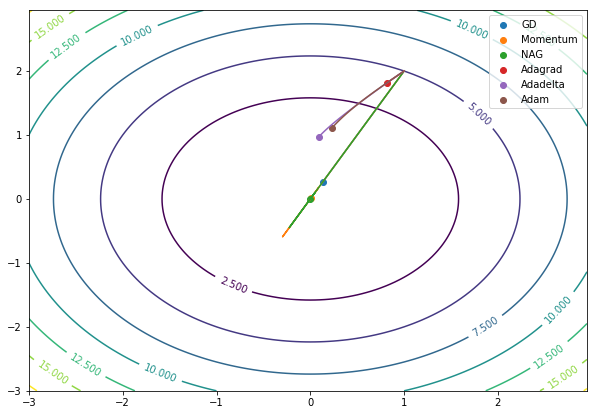

In [131]:
f = lambda X: X[0]**2 + X[1]**2
df = lambda X: np.array([2 * X[0], 2 * X[1]])

plot(f, df, (1, 2), 100)
        

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

GD: [0.03245907 0.03365101]
Momentum: [-2.28892973 -2.28892973]
NAG: [-2.28892973 -2.28892973]
Adagrad: [0.50193694 1.34107882]
Adadelta: [4.32604370e-06 4.98345805e-06]
Adam: [0.01482818 0.04007   ]


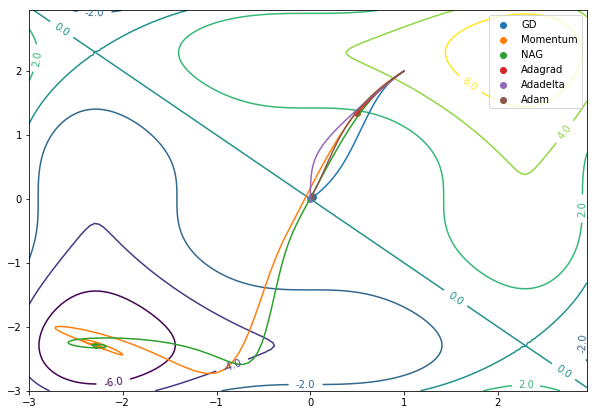

In [83]:
f = lambda X: (X[0]**2) * np.sin(X[0]) + (X[1]**2) * np.sin(X[1])
df = lambda X: np.array([2*X[0]*np.sin(X[0]) + X[0]**2 * np.cos(X[0]), 
                         2*X[1]*np.sin(X[1]) + X[1]**2 * np.cos(X[1])])

plot(f, df, (1, 2), 1000)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

GD: [0.1564606  2.21656952]
Momentum: [-0.04786472  2.21656952]
NAG: [-0.04894457  2.21656952]
Adagrad: [0.64328271 2.215617  ]
Adadelta: [2.13703739e-03 2.22153177e+00]
Adam: [0.1349436  2.21656952]


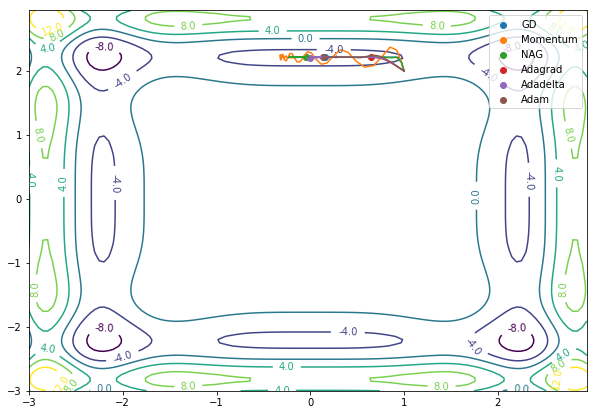

In [81]:
f = lambda X: (X[0] ** 2) * np.sin(X[0]**2) + (X[1]**2) * np.sin(X[1]**2)
df = lambda X: np.array([2 * X[0] * np.sin(X[0]**2) + 2 * (X[0]**3) * np.cos(X[0]**2),
                         2 * X[1] * np.sin(X[1]**2) + 2 * (X[1]**3) * np.cos(X[1]**2)])

plot(f, df, (1, 2), 500)

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [86]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:08, 1180989.86it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 81526.23it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:03, 501294.77it/s]                             
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


8192it [00:00, 27093.35it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [108]:
def train(network, epochs, learning_rate, optim, conv=True):
    loss = nn.NLLLoss()
    optimizer = optim(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                if (conv):
                    X = X.view(X.size(0), -1)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                if (conv):
                    X = X.view(X.size(0), -1)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 9... (Train/Test) NLL: 0.020/0.100	Accuracy: 0.993/0.977


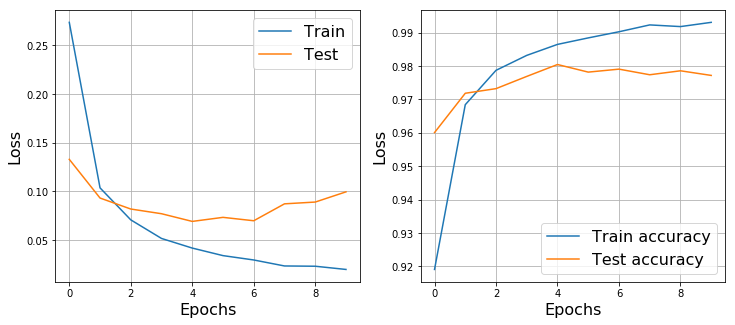

In [92]:
network = nn.Sequential(nn.Linear(784, 200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001, optim=torch.optim.Adam)

Epoch 9... (Train/Test) NLL: 0.190/0.186	Accuracy: 0.946/0.946


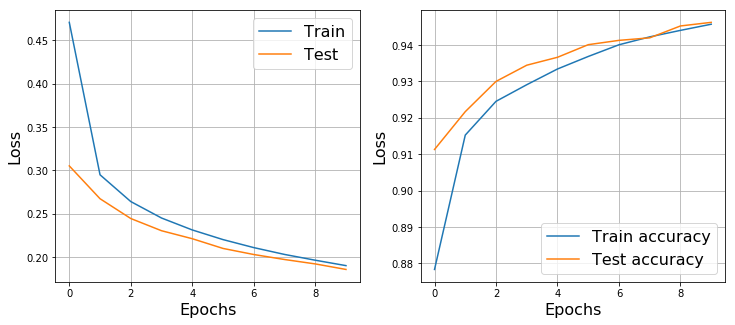

In [93]:
network = nn.Sequential(nn.Linear(784, 200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001, optim=torch.optim.Adagrad)

Epoch 9... (Train/Test) NLL: 0.845/0.785	Accuracy: 0.819/0.831


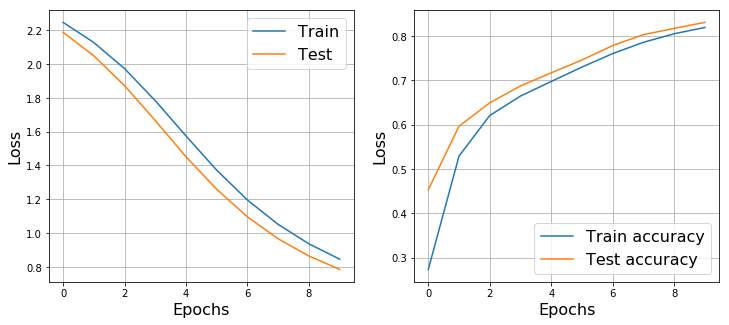

In [94]:
network = nn.Sequential(nn.Linear(784, 200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001, optim=torch.optim.Adadelta)

Epoch 9... (Train/Test) NLL: 0.492/0.458	Accuracy: 0.873/0.882


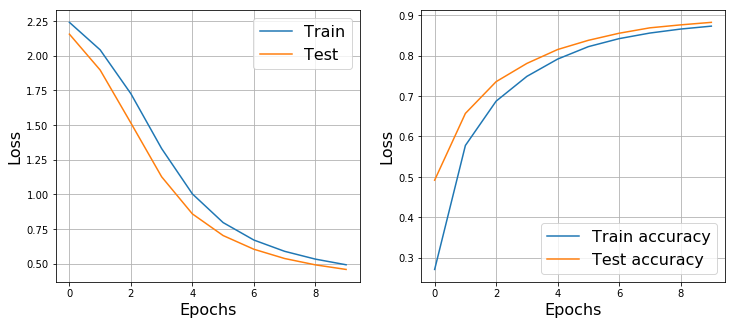

In [95]:
network = nn.Sequential(nn.Linear(784, 200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001, optim=torch.optim.SGD)

Adam дает наилучший результат, но достаточно сильно переобучается. Остальные методы оптимизации меньше подвержены переобучению, значения на train и test практически совпадают

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [104]:
image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), 
                                         nn.ReLU(), 
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding=1),
                                         nn.ReLU())
                                         
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*16, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 9... (Train/Test) NLL: 0.020/0.044	Accuracy: 0.994/0.985


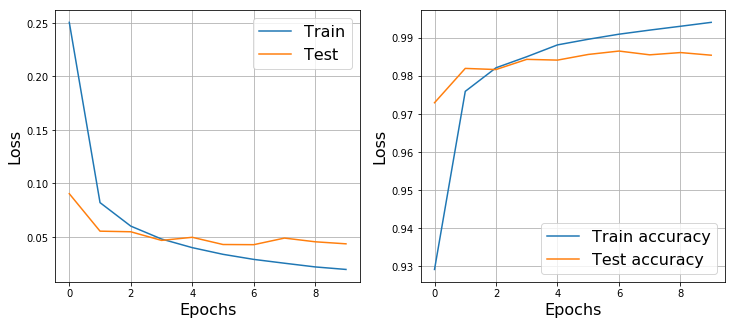

In [109]:
network = ConvClassifier(image_size=28)
train(network, 10, 0.001, conv=False, optim=torch.optim.Adam)

Epoch 9... (Train/Test) NLL: 0.198/0.187	Accuracy: 0.943/0.947


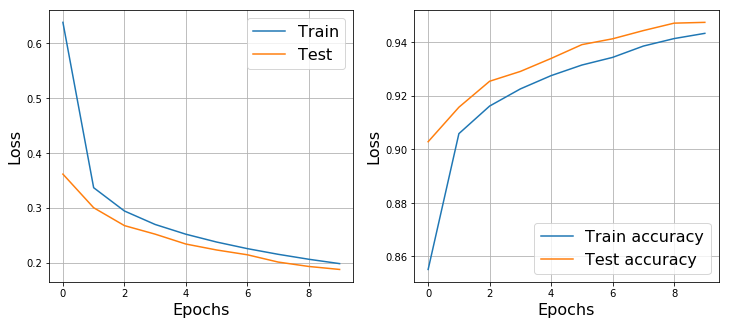

In [110]:
network = ConvClassifier(image_size=28)
train(network, 10, 0.001, conv=False, optim=torch.optim.Adagrad)

Epoch 9... (Train/Test) NLL: 0.502/0.472	Accuracy: 0.863/0.874


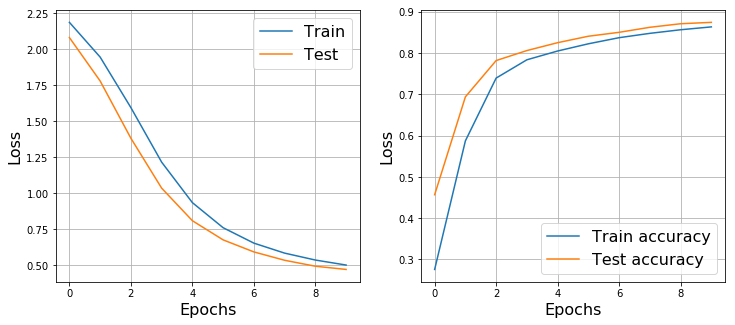

In [111]:
network = ConvClassifier(image_size=28)
train(network, 10, 0.001, conv=False, optim=torch.optim.Adadelta)

Epoch 9... (Train/Test) NLL: 0.299/0.281	Accuracy: 0.912/0.920


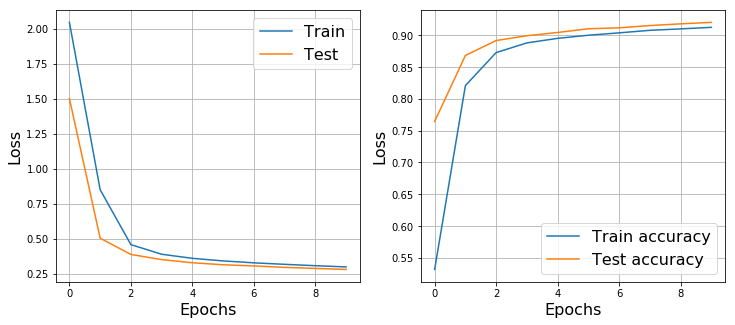

In [112]:
network = ConvClassifier(image_size=28)
train(network, 10, 0.001, conv=False, optim=torch.optim.SGD)

Результаты на сверточных сетях аналогичны результатам на полносвязных. При этом, Adam дает чуть лучший результат на сверточной чети, чем на полносвязной

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: